# Binary Classification using Tensorflow and Keras by developing Feed-Forward Neural Networks.

## Problem Statement: Predicting 'red wine quality'. 
- If Quality >= 5.5, then it is **'good wine'** (1).
- Otherwise it is **'bad wine'** (0).

---

## Initial Step: Load the Data

Key Questions before pre-processing are
1) How many rows and columns does the data have?
2) How do we load a dataset that has non-numbers?
    - To do so, you could load the dataset in a separate file, and write a script to convert non-numerical data to numerical.

In [156]:
import numpy as np

# Load the dataset, skipping the first row (headers) and selecting only numerical columns
dataset = np.loadtxt('WineQT.csv', delimiter=',', skiprows=1, usecols=range(12))

# Print dataset dimensions
print(dataset.shape)

(1143, 12)


In [157]:
import pandas as pd

# Convert dataset to a Pandas Dataframe for easier analysis
df = pd.DataFrame(dataset)

print(df.head())    # Display first 5 rows


     0     1     2    3      4     5     6       7     8     9    10   11
0   7.4  0.70  0.00  1.9  0.076  11.0  34.0  0.9978  3.51  0.56  9.4  5.0
1   7.8  0.88  0.00  2.6  0.098  25.0  67.0  0.9968  3.20  0.68  9.8  5.0
2   7.8  0.76  0.04  2.3  0.092  15.0  54.0  0.9970  3.26  0.65  9.8  5.0
3  11.2  0.28  0.56  1.9  0.075  17.0  60.0  0.9980  3.16  0.58  9.8  6.0
4   7.4  0.70  0.00  1.9  0.076  11.0  34.0  0.9978  3.51  0.56  9.4  5.0


In [158]:
# Load dataset with headers for better column identification
df = pd.read_csv('WineQT.csv')  
df.head()   # Show first few rows

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [159]:
# Drop 'Id' column since it's useless for training
df = df.drop(columns=['Id'])

In [160]:
# Display data set info now
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


In [161]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Convert the dataset back to a NumPy array because all calculations, preprocessing, and execution will be done using NumPy, but I initially used Pandas for easier inspection.

In [162]:
dataset = df.to_numpy()

---

## Step 1: Preview the first 5 rows.

In [163]:
# Prints only floating point numbers with a 2 decimal point precision. 
np.set_printoptions(formatter={'float': lambda x: '{0:0.2f}'.format(x)})

print(dataset[0:20, :])  # Display rows 0 to 4 with all columns

[[7.40 0.70 0.00 1.90 0.08 11.00 34.00 1.00 3.51 0.56 9.40 5.00]
 [7.80 0.88 0.00 2.60 0.10 25.00 67.00 1.00 3.20 0.68 9.80 5.00]
 [7.80 0.76 0.04 2.30 0.09 15.00 54.00 1.00 3.26 0.65 9.80 5.00]
 [11.20 0.28 0.56 1.90 0.07 17.00 60.00 1.00 3.16 0.58 9.80 6.00]
 [7.40 0.70 0.00 1.90 0.08 11.00 34.00 1.00 3.51 0.56 9.40 5.00]
 [7.40 0.66 0.00 1.80 0.07 13.00 40.00 1.00 3.51 0.56 9.40 5.00]
 [7.90 0.60 0.06 1.60 0.07 15.00 59.00 1.00 3.30 0.46 9.40 5.00]
 [7.30 0.65 0.00 1.20 0.07 15.00 21.00 0.99 3.39 0.47 10.00 7.00]
 [7.80 0.58 0.02 2.00 0.07 9.00 18.00 1.00 3.36 0.57 9.50 7.00]
 [6.70 0.58 0.08 1.80 0.10 15.00 65.00 1.00 3.28 0.54 9.20 5.00]
 [5.60 0.61 0.00 1.60 0.09 16.00 59.00 0.99 3.58 0.52 9.90 5.00]
 [7.80 0.61 0.29 1.60 0.11 9.00 29.00 1.00 3.26 1.56 9.10 5.00]
 [8.50 0.28 0.56 1.80 0.09 35.00 103.00 1.00 3.30 0.75 10.50 7.00]
 [7.90 0.32 0.51 1.80 0.34 17.00 56.00 1.00 3.04 1.08 9.20 6.00]
 [7.60 0.39 0.31 2.30 0.08 23.00 71.00 1.00 3.52 0.65 9.70 5.00]
 [7.90 0.43 0.21 1.60 0

---

## Step 2: Prepare the output

If the last column is less than 5.5, set it to 0, otherwise 1.
- (good wine = 1, bad wine = 0)

In [164]:
dataset[dataset[:, -1] < 5.5, -1] = 0
dataset[dataset[:, -1] >= 5.5, -1] = 1

print(dataset[0:20, :])

[[7.40 0.70 0.00 1.90 0.08 11.00 34.00 1.00 3.51 0.56 9.40 0.00]
 [7.80 0.88 0.00 2.60 0.10 25.00 67.00 1.00 3.20 0.68 9.80 0.00]
 [7.80 0.76 0.04 2.30 0.09 15.00 54.00 1.00 3.26 0.65 9.80 0.00]
 [11.20 0.28 0.56 1.90 0.07 17.00 60.00 1.00 3.16 0.58 9.80 1.00]
 [7.40 0.70 0.00 1.90 0.08 11.00 34.00 1.00 3.51 0.56 9.40 0.00]
 [7.40 0.66 0.00 1.80 0.07 13.00 40.00 1.00 3.51 0.56 9.40 0.00]
 [7.90 0.60 0.06 1.60 0.07 15.00 59.00 1.00 3.30 0.46 9.40 0.00]
 [7.30 0.65 0.00 1.20 0.07 15.00 21.00 0.99 3.39 0.47 10.00 1.00]
 [7.80 0.58 0.02 2.00 0.07 9.00 18.00 1.00 3.36 0.57 9.50 1.00]
 [6.70 0.58 0.08 1.80 0.10 15.00 65.00 1.00 3.28 0.54 9.20 0.00]
 [5.60 0.61 0.00 1.60 0.09 16.00 59.00 0.99 3.58 0.52 9.90 0.00]
 [7.80 0.61 0.29 1.60 0.11 9.00 29.00 1.00 3.26 1.56 9.10 0.00]
 [8.50 0.28 0.56 1.80 0.09 35.00 103.00 1.00 3.30 0.75 10.50 1.00]
 [7.90 0.32 0.51 1.80 0.34 17.00 56.00 1.00 3.04 1.08 9.20 1.00]
 [7.60 0.39 0.31 2.30 0.08 23.00 71.00 1.00 3.52 0.65 9.70 0.00]
 [7.90 0.43 0.21 1.60 0

We have now converted this problem into a **binary classification** problem because our output labels are now 0's and 1's. 

Proposed question: What happens if we reverse the two statements that replace wine quality with binary values?

---

## Step 3: Shuffle the rows

This is done simply to get a good mix of all of the rows. It may be bad for reproducibility, but it is good for reliability. Why?
- every time you shuffle you will get completely different results, but it more or less guarantees that you won't get all 0's in the training or 1's in the testing and vice versa.

In [165]:
import random
np.random.shuffle(dataset) 

---

## Step 4: Split into Training/Testing data.

All the input values that go into the model are Xtrain, and what the model needs to predict is Ytrain.

Proposed rule of thumb is an 80/20 split for training and testing.

In [166]:
index_20percent = int(0.2 * len(dataset[:, 0]))

print(index_20percent)  # 228 samples will be tested

228


In [167]:
# Take samples from start to 228 for Testing
XTEST = dataset[:index_20percent, :-1]  # Extract all columns except the last into X (indicated by :-1)
YTEST = dataset[:index_20percent, -1]   # Extract last column only into y

In [168]:
# Take samples from 228 onwards (: indicates this)
XTRAIN = dataset[index_20percent:, 0:-1]    # Extract all columns besides last
YTRAIN = dataset[index_20percent:, -1]       # Extract only last

---

## Step 5: Normalize the data (if needed)

Not all datasets need normalization, but if your input column values do not necessarily sit around 0-1 then you may need to normalize

Common practice to normalize is to use standardization.

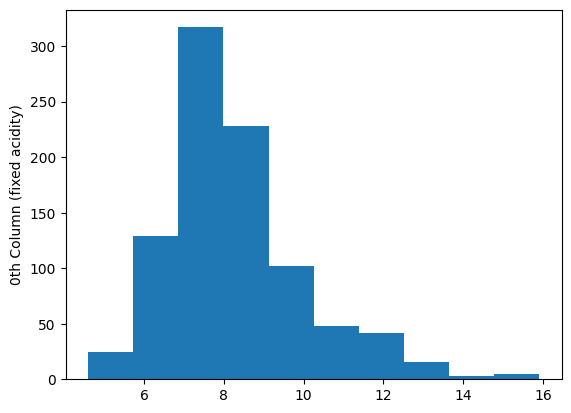

In [169]:
import matplotlib.pyplot as plt

plt.hist(XTRAIN[:, 0])
plt.ylabel('0th Column (fixed acidity)')
plt.show()

The 0th column 'fixed acidity has values ranging from roughly 3-15, and most are in the 6-10 region.

So, since these values are not in the 0-1 range we want to normalize them. 

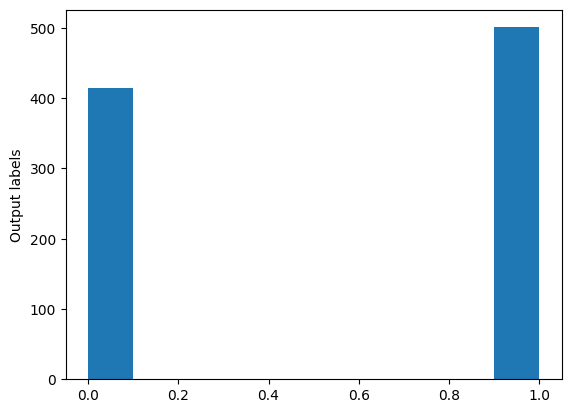

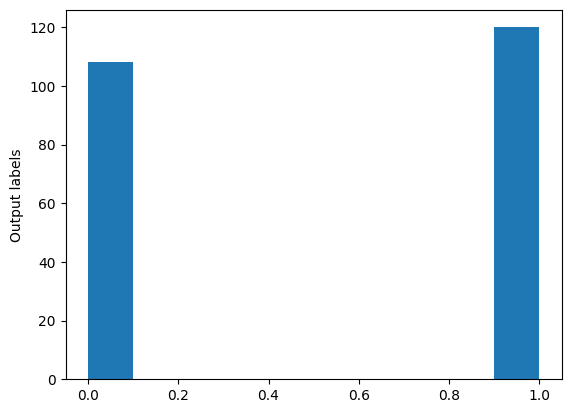

In [170]:
# Check the split of 0's and 1's in our Y-data, aka what we are predicting.

plt.hist(YTRAIN)
plt.ylabel('Output labels')
plt.show()

plt.hist(YTEST)
plt.ylabel('Output labels')
plt.show()

**Baseline Accuracy** is determined by this split, as if you have more of one value than the other the baseline accuracy will be greater than or less than 50%.

Now, lets normalize the data with standardization:

In [171]:
# You obtain the mean and standard deviation from your training data
# Then use those values to normalize your testing data

mean = XTRAIN.mean(axis=0)
XTRAIN -= mean
std = XTRAIN.std(axis=0)
XTRAIN /= std

XTEST -= mean
XTRAIN /= std

It is important to calculate the mean and std using the training data, and subsequently use the same values for the testing data. Why?
- You only use the training data to calculate mean and std as a **True Test** of the model how it does on testing data using the parameters learned from the training set.

In [172]:
# mean and std are vectors
# So, we can see the mean and std for each feature we have

print(mean)
print(std)

[8.28 0.53 0.27 2.53 0.09 15.59 45.88 1.00 3.31 0.66 10.44]
[1.73 0.18 0.20 1.30 0.05 10.12 32.87 0.00 0.16 0.17 1.10]


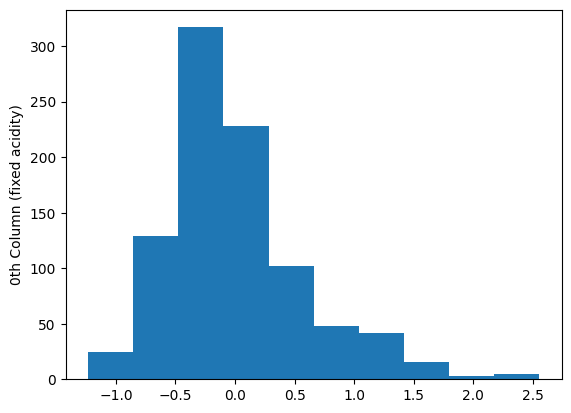

In [173]:
# Now, look at the distribution of values for the same column again. 

plt.hist(XTRAIN[:, 0])
plt.ylabel('0th Column (fixed acidity)')
plt.show()

---

## Step 6: Review the Dimensions of the training & testing sets.

Also previews some of the 'input features' and 'correct labels' for the datasets.

In [174]:
# The number of rows in XTRAIN & YTRAIN must be the same.
print(XTRAIN.shape)
print(YTRAIN.shape)

(915, 11)
(915,)


In [175]:
# Same goes for the testing sets.
print(XTEST.shape)
print(YTEST.shape)

(228, 11)
(228,)


In [176]:
# Print the head (first 3) of the datasets
print(XTRAIN[0:3, ])
print(YTRAIN[0:3])
print(XTEST[0:3, ])
print(YTEST[0:3])

[[0.27 -4.22 7.67 1.22 -3.10 -0.09 -0.02 -54.73 -1.38 -2.99 1.70]
 [-0.36 6.10 -5.46 1.25 -0.58 -0.11 -0.03 -142.32 3.83 -9.24 0.38]
 [0.27 7.69 -1.17 -0.19 -3.52 -0.04 0.00 240.91 -5.39 -5.08 -0.69]]
[1.00 0.00 0.00]
[[1.52 -0.03 0.22 0.07 0.16 -10.59 -25.88 0.00 -0.00 0.13 0.26]
 [-1.58 0.05 -0.19 -0.73 0.01 -0.59 19.12 -0.00 -0.03 -0.12 -1.24]
 [-1.48 0.03 -0.24 -0.83 -0.00 2.41 -10.88 0.00 0.13 -0.03 -0.44]]
[1.00 0.00 1.00]


---

## Step 7: Create a neural network model

We want to create a network with the following architecture:
- 8 neurons in layer 1
- 4 neurons in layer 2
- 1 neuron as the last layer

In [177]:
from tensorflow.keras.models import Sequential  # Sequential model to stack layers
from tensorflow.keras.layers import Dense       # Dense layer aka fully connected layer

# Initialize a Sequential model (stacks layers in order)
model = Sequential()

# The number of inputs that each neuron receives is the number of columns in the data
model.add(Dense(8, input_dim = len(XTRAIN[0, :]), activation='relu'))

# input_dim = len(XTRAIN[0, :]) calculates the length by using the first row (0) and all columns(:)
# Necessary for first layer as each neuron needs to know how many inputs it is receiving when designing the architecture of the NN.

# All of the outputs from the 8 neurons in layer 1 become inputs to the 4 neurons in layer 2
model.add(Dense(4, activation='relu'))

# Since we are doing binary classification, we want 1 neuron in the last layer.
model.add(Dense(1, activation='sigmoid'))

c:\Users\Jorwi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Why ReLU and Sigmoid?
- **ReLU (`relu`)** is used in hidden layers to introduce non-linearity. It helps the model learn complex patterns and prevents the vanishing gradient problem.
- **Sigmoid (`sigmoid`)** is used in the output layer for binary classification. It converts raw scores (logits) into probabilities between 0 and 1.
- **Logits** are the raw, unscaled outputs of a neuron before applying an activation function. They can take any real value, but we apply an activation function (like `sigmoid`) to convert them into interpretable probabilities.
- **The Vanishing Gradient Problem** happens when the learning signal (gradient) becomes too small, making earlier layers in a deep network stop learning. This is like trying to learn from feedback that gets quieter and quieter until you can’t hear it anymore. ReLU helps fix this by keeping gradients strong and allowing deeper layers to keep learning.

In [178]:
# Display model architecture
print(model.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 8)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137 (548.00 B)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 0 (0.00 B)

None


The `model.summary()` function provides a structured overview of the neural network, showing key details about each layer:

- **Layer Type**: Lists the different layers in the model (e.g., `Dense` for fully connected layers).  
- **Output Shape**: Displays the shape of the data as it moves through each layer.  
  - `(None, 8)`, `(None, 4)`, `(None, 1)` → The `None` indicates that the model can process any batch size.  
  - The numbers (8, 4, 1) represent the number of neurons in each layer.  
- **Number of Parameters**: Shows how many **trainable weights (connections between neurons) and biases (offset values for neurons)** each layer contains. For example, the first layer has **96 parameters** because 11*8 (weights) = 88 + 8 (biases) = 96.
- **Total Parameters**: The sum of all layer parameters, indicating the complexity of the model.  
- **Trainable Parameters**: The parameters that are updated during training.  
- **Non-Trainable Parameters**: Parameters that are fixed (e.g., from a pre-trained model).

### **Why This is Useful**
- Helps ensure the architecture is **correctly structured** before training.  
- Provides insight into the **model’s complexity** (more parameters = more capacity, but also risk of overfitting).  
- Useful for **debugging** if unexpected shapes or parameter mismatches occur.  


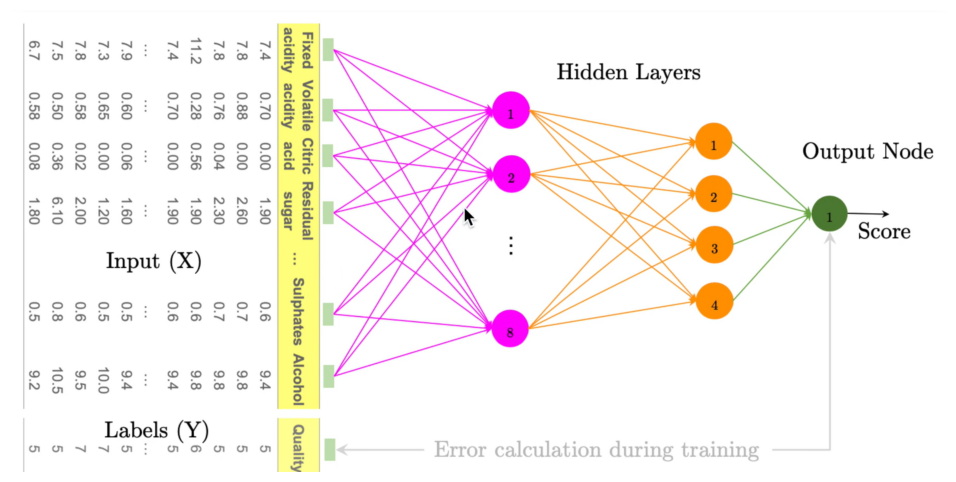

In [179]:
import matplotlib.image as mpimg

plt.figure(figsize=(15, 6))

img = mpimg.imread('NN.png')
plt.imshow(img)
plt.axis('off')
plt.show()

All the input features go into the network in a different way than the output. 

The 11 different features (columns) go into the 8 neurons in the 1st layer, from each column to every neuron. 

Those 8 neurons then feed the 4 neurons, and those 4 feed the final neuron that sits at the end. 

That final neuron, based on all the previous weights and calculations gives you an accuracy score from 0 to 1. 

If the score is bad, then the weights that connect the nodes need to be updated such that in future rounds of training the output matches closer with the input. 

---

## Step 8: Compile the model

This checks if there are cycles in the **sequential model**.

Typically, when designing sequential models there are usually no errors.

In [180]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

When defining the loss, for binary classification **binary crossentropy** is the only choice. Why?
- **Binary crossentropy** is used for binary classification because it measures how well the predicted probabilities match the actual class labels, making it ideal for problems with two possible outcomes.

For optimizer, we chose *adam* but could have chosen any adaptive optimizer like *rmsprop*.
- Adaptive optimizers automatically adjust the learning rate during training, allowing for faster and more stable convergence compared to fixed learning rate optimizers like SGD.
- **Adam (Adaptive Moment Estimation)** is an optimizer that combines the advantages of both RMSprop and momentum, making it effective for most deep learning tasks.
- **RMSprop (Root Mean Square Propagation)** is another optimizer that adapts the learning rate for each parameter, preventing large updates that can slow down convergence.
- **Momentum Optimizer** accelerates training by allowing the optimizer to keep moving in the same direction even if gradients change slightly, helping escape small local minima and improving convergence speed.

For **binary classification** the most widely used metric is *accuracy* as it is easier to understand.

---

## Step 9: Train the model

We feed *XTRAIN* into the model and the model calculates errors using *YTRAIN*.

In one *epoch* the model scans through all the rows in *XTRAIN*.

- An **epoch** is one full pass through of the entire dataset.

Updating the number of *epochs* usually increases the accuracy of the model, as the more often that the training process sees the entire dataset the more likely it is to get better on it. 

We add *test_data = (XTEST, YTEST)* to observe the accuracy of *TEST* data during the training process.

In [181]:
# Add some callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

callback_a = ModelCheckpoint(filepath = 'my_best_model.keras', monitor='val_loss', save_best_only = True)   # Prevents saving worse models
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)                          # Prevents overfitting

## Callbacks: ModelCheckpoint & EarlyStopping
We added them to improve the model's training efficiency.
- **Model Checkpoint** saves the best model based on validation loss.
- **Early Stopping** stops the model if the validation loss does not decrease for 20 epochs. 
- **Validation Loss** measures how well the model performs on unseen data. A low validation loss means the model is learning patterns that generalize well, while a high validation loss may indicate overfitting.


In [182]:
history = model.fit(XTRAIN, YTRAIN, validation_data=(XTEST, YTEST), epochs=256, batch_size=10, callbacks=[callback_a, callback_b])

Epoch 1/256
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4919 - loss: 4.5595 - val_accuracy: 0.6360 - val_loss: 0.9937
Epoch 2/256
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5503 - loss: 0.8486 - val_accuracy: 0.6404 - val_loss: 1.0094
Epoch 3/256
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5902 - loss: 0.7482 - val_accuracy: 0.6360 - val_loss: 1.0444
Epoch 4/256
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5722 - loss: 0.7037 - val_accuracy: 0.6360 - val_loss: 1.0795
Epoch 5/256
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6108 - loss: 0.6637 - val_accuracy: 0.6316 - val_loss: 1.1208
Epoch 6/256
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5856 - loss: 0.6651 - val_accuracy: 0.6360 - val_loss: 1.1677
Epoch 7/256
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6226 - loss: 0.6109 - val_accuracy: 0.6360 - val_loss: 1.2125
Epoch 8/256
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5679 - loss: 0.6548 - val_accuracy: 0.6404 - v

---

## Step 10: Check the learning curves

- The learning curves are the loss, accuracy, etc... over the number of epochs.
- Learning curves can only be tracked if we used history when training the model, as that is what stores the output of the model during training. 

In [183]:
print(history.params)

{'verbose': 'auto', 'epochs': 256, 'steps': 92}


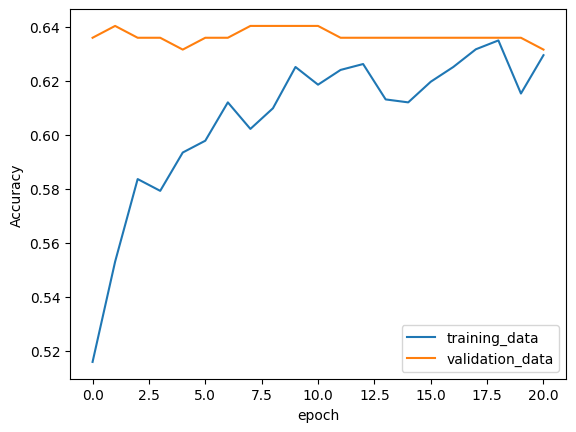

In [184]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['training_data', 'validation_data'], loc='lower right')
plt.show()

- The training accuracy steadily increased, meaning the model is learning the training data well. 
- The validation accuracy increased initially, but flattens and slightly fluctuated, meaning that after some epochs, the model stopped improving on unseen data. 

This suggests overfitting, meaning the model memorized the training data instead of generalizing well to new data. 

Reload the best weights so we are back with the highest performing model on the testing set. 

In [185]:
model.load_weights('my_best_model.keras')

---

## Step 11: Evaluate the model on the training data

This is done to validate the results we got on the Testing set. 

We are evaluating the model on the same data we used to train it, so essentially this evaluation is meaningless. But, it is done to make sure everything is working okay. 

In [186]:
scores = model.evaluate(XTRAIN, YTRAIN)
print(model.metrics_names)
print(scores)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5474 - loss: 0.7911
['loss', 'compile_metrics']
[0.7955260276794434, 0.5606557130813599]

compile_metrics: 56.07%


Displays the accuracy.

---

## Step 12: Evaluate on testing set

This is a **real test** on the model as we are evaluating it on the 'unknown' dataset, aka unseen data. 

In [187]:
scores = model.evaluate(XTEST, YTEST)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6270 - loss: 1.0592 

compile_metrics: 63.60%


lower than the training evaluation.

---

## Step 13: Check what the model actually predicts

This is an example of what the model has predicted and a subsequent comparison with the true classes.

In [188]:
print(XTEST[0:5])
print(YTEST[0:5])

[[1.52 -0.03 0.22 0.07 0.16 -10.59 -25.88 0.00 -0.00 0.13 0.26]
 [-1.58 0.05 -0.19 -0.73 0.01 -0.59 19.12 -0.00 -0.03 -0.12 -1.24]
 [-1.48 0.03 -0.24 -0.83 -0.00 2.41 -10.88 0.00 0.13 -0.03 -0.44]
 [-1.38 0.56 -0.21 -0.43 -0.03 -3.59 -14.88 -0.00 0.20 -0.23 0.96]
 [0.02 -0.25 0.21 -0.43 0.01 -9.59 -33.88 -0.00 -0.05 -0.04 1.96]]
[1.00 0.00 1.00 0.00 1.00]


In [189]:
prediction = model.predict(XTEST)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [190]:
print(prediction[0:10])

[[0.59]
 [0.03]
 [0.54]
 [0.55]
 [0.63]
 [0.58]
 [0.56]
 [0.68]
 [0.00]
 [0.58]]


We see that the confidence scores are not matching in some areas.

In [191]:
print(prediction[0:10].round())

[[1.00]
 [0.00]
 [1.00]
 [1.00]
 [1.00]
 [1.00]
 [1.00]
 [1.00]
 [0.00]
 [1.00]]


This is clearer once we round. 

The following scatter plot visualizes the relationship between the **true labels (X-axis)** and the **predicted confidence scores (Y-axis)**.  

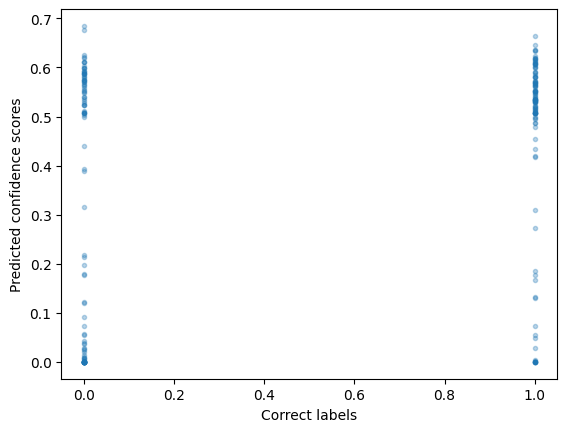

In [192]:
plt.plot(YTEST, prediction, '.', alpha=0.3)
plt.xlabel('Correct labels')
plt.ylabel('Predicted confidence scores')
plt.show()

- Each point represents a **single prediction** made by the model.  
- The X-axis (Correct labels) shows the actual class labels **(0 = bad wine, 1 = good wine)**.  
- The Y-axis (Predicted confidence scores) shows the **model’s confidence** in classifying the sample as **good wine (1)**.  

**Interpreting the Graph:**  
- **Points close to 0 or 1 on the Y-axis** = The model is confident in its predictions.  
- **Points near 0.5** = The model is uncertain, meaning the classification is less reliable.  
- **Ideally**, predictions for class **0** should cluster near the bottom (low confidence), and predictions for class **1** should cluster near the top (high confidence).  
- **If many points are incorrectly positioned**, the model may struggle with classification, possibly due to overfitting or imbalanced data.  

This visualization helps identify patterns in model confidence and potential areas for improvement.  

---

## Key Question: Is 'accuracy' sufficient enough to evaluate our model?

Many times, accuracy may not be the best metric to evaluate what our model is predicting. **Accuracy can be misleading** if the dataset is **imbalanced** (ex: predicting 99% "negative" in a dataset where 99% of cases are negative still gives high accuracy but fails to detect positives).

To further assess the model's performance, we used the following metrics:

- **Accuracy**: Measures the percentage of correct predictions.  
  - **High** = The model is making mostly correct predictions.  
  - **Low** = The model is performing poorly, possibly just guessing.

- **Precision**: Measures how often a predicted positive is actually correct.  
  - **High** = Few false positives, reliable positive predictions.  
  - **Low** = Many false positives, model predicts positives incorrectly too often.  

- **Recall (Sensitivity)**: Measures how well the model detects actual positives.  
  - **High** = Few false negatives, model catches most actual positives.  
  - **Low** = Many false negatives, missing actual positive cases.  

- **F1-Score**: A balance between precision and recall.  
  - **High** = Both precision and recall are strong.  
  - **Low** = One or both metrics are weak, indicating poor overall performance.  

In [193]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(YTEST, prediction.round())
precision = precision_score(YTEST, prediction.round())
recall = recall_score(YTEST, prediction.round())
f1score = f1_score(YTEST, prediction.round())

print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1-score: %.2f" % (f1score))

Accuracy: 63.60%
Precision: 63.12%
Recall: 74.17%
F1-score: 0.68


---

## Key Question: How can the performance be improved?

First we could increase the number of epochs to 100 or 150

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6126 - loss: 0.6098 - val_accuracy: 0.6404 - val_loss: 1.4307
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5764 - loss: 0.6188 - val_accuracy: 0.6404 - val_loss: 1.4574
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6133 - loss: 0.5980 - val_accuracy: 0.6360 - val_loss: 1.4904
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6372 - loss: 0.6267 - val_accuracy: 0.6360 - val_loss: 1.5137
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6145 - loss: 0.6645 - val_accuracy: 0.6316 - val_loss: 1.5415
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6239 - loss: 0.6223 - val_accuracy: 0.6316 - val_loss: 1.5652
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6138 - loss: 0.5947 - val_accuracy: 0.6316 - val_loss: 1.5875
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6341 - loss: 0.6200 - val_accuracy: 0.6316 - v

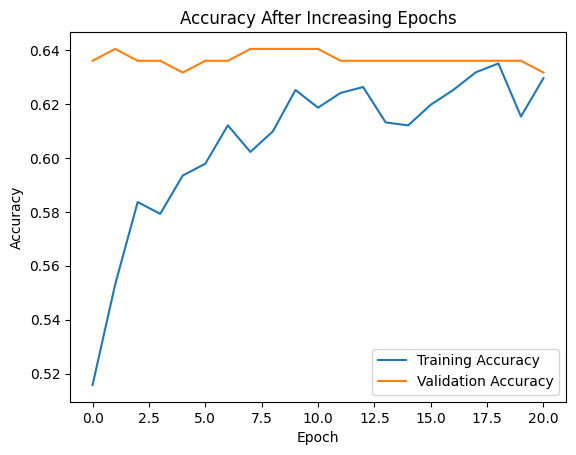

In [195]:
## **Testing Improvement 1: Increasing Epochs**
# Increase the number of epochs to **100** and observe if the model improves.

model.fit(XTRAIN, YTRAIN, validation_data=(XTEST, YTEST), epochs=100, batch_size=32, callbacks=[callback_a])

# Display final accuracy after increasing epochs
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Plot accuracy over 100 epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy After Increasing Epochs')
plt.show()

Or we could add more layers to the neural networks

Epoch 1/50


c:\Users\Jorwi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4539 - loss: 5.2025 - val_accuracy: 0.6096 - val_loss: 0.8267
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5591 - loss: 1.0735 - val_accuracy: 0.6491 - val_loss: 0.8140
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5604 - loss: 0.7654 - val_accuracy: 0.6360 - val_loss: 0.8137
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5260 - loss: 0.7341 - val_accuracy: 0.6272 - val_loss: 0.8089
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5724 - loss: 0.6934 - val_accuracy: 0.6316 - val_loss: 0.7981
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5899 - loss: 0.6712 - val_accuracy: 0.6316 - val_loss: 0.7924
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5943 - loss: 0.6642 - val_accuracy: 0.6404 - val_loss: 0.7845
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5806 - loss: 0.6788 - val_accuracy: 0.6316 - val_loss: 0.7795
Ep

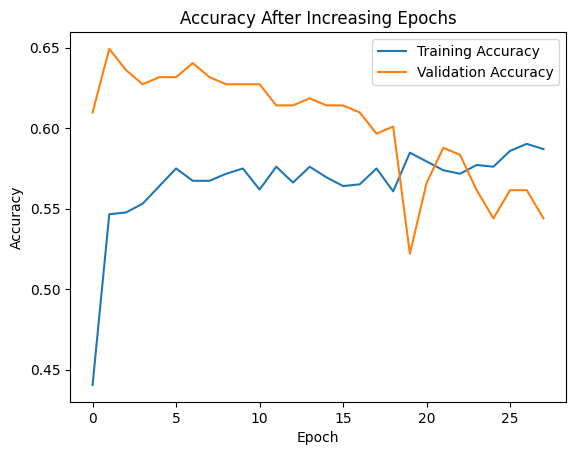

In [196]:
## **Testing Improvement 2: Adding More Layers**
# We'll add an additional hidden layer (making it a **4-layer network**) and see if performance improves.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define new model with an extra hidden layer
model2 = Sequential()
model2.add(Dense(8, input_dim=len(XTRAIN[0, :]), activation='relu'))
model2.add(Dense(6, activation='relu'))  # New layer added
model2.add(Dense(4, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the new model
history2 = model2.fit(XTRAIN, YTRAIN, validation_data=(XTEST, YTEST), epochs=50, batch_size=32, callbacks=[callback_a, callback_b])

# Display final accuracy after increasing epochs
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Plot accuracy over 100 epochs
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy After Increasing Epochs')
plt.show()

We could also balance the data, meaning create a good balance of positive and negative class values so the evaluation makes sense 

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7092 - loss: 0.5709 - val_accuracy: 0.6228 - val_loss: 4.8698
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7305 - loss: 0.5464 - val_accuracy: 0.6228 - val_loss: 4.9348
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7170 - loss: 0.5326 - val_accuracy: 0.6272 - val_loss: 4.9885
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7354 - loss: 0.5300 - val_accuracy: 0.6272 - val_loss: 5.0294
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7284 - loss: 0.5424 - val_accuracy: 0.6272 - val_loss: 5.0738
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7275 - loss: 0.5421 - val_accuracy: 0.6272 - val_loss: 5.1335
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7410 - loss: 0.5334 - val_accuracy: 0.6272 - val_loss: 5.1794
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7326 - loss: 0.5396 - val_accuracy: 0.6272 - val_loss:

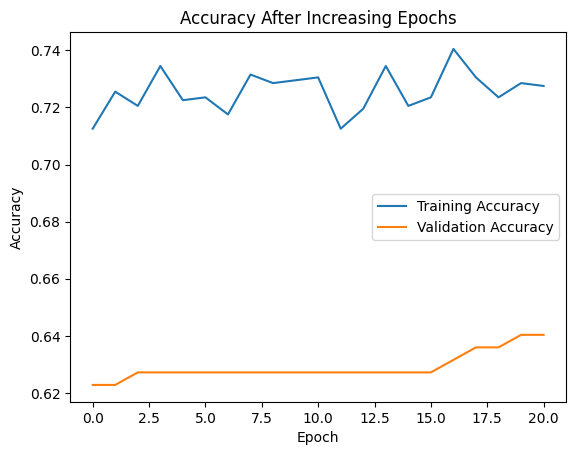

In [197]:
## **Testing Improvement 3: Balancing the Data**
# We'll use **random oversampling** to balance the classes and see if it helps improve model performance.

from imblearn.over_sampling import RandomOverSampler

# Apply oversampling to balance the dataset
ros = RandomOverSampler()
XTRAIN_resampled, YTRAIN_resampled = ros.fit_resample(XTRAIN, YTRAIN)

# Train model on the balanced dataset
history3 = model.fit(XTRAIN_resampled, YTRAIN_resampled, validation_data=(XTEST, YTEST), epochs=50, batch_size=32, callbacks=[callback_a, callback_b])

# Display final accuracy after increasing epochs
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Plot accuracy over 100 epochs
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy After Increasing Epochs')
plt.show()

Finally, we could increase/decrease the number of rows in the training/testing set, meaning alter the split

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7290 - loss: 0.9550 - val_accuracy: 0.6228 - val_loss: 5.4340
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7123 - loss: 0.8667 - val_accuracy: 0.6228 - val_loss: 4.6588
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7428 - loss: 0.7649 - val_accuracy: 0.6140 - val_loss: 4.1605
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7280 - loss: 0.9627 - val_accuracy: 0.6140 - val_loss: 3.7382
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7397 - loss: 0.6981 - val_accuracy: 0.6228 - val_loss: 3.4712
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7220 - loss: 0.7295 - val_accuracy: 0.6404 - val_loss: 3.0949
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7061 - loss: 0.7773 - val_accuracy: 0.6404 - val_loss: 2.9099
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7441 - loss: 0.6529 - val_accuracy: 0.6491 - val_loss:

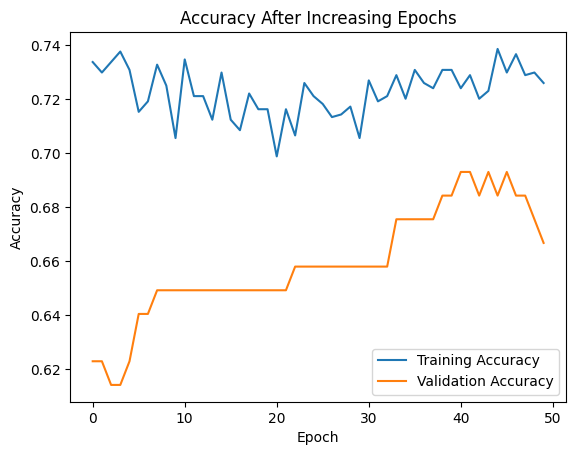

In [198]:
## **Testing Improvement 4: Adjusting Train/Test Split**
# We'll change the train/test split to **90% train, 10% test** and check its effect.

# Adjust train/test split to 90% train, 10% test
index_10percent = int(0.1 * len(dataset[:, 0]))

XTEST_new = dataset[:index_10percent, :-1]
YTEST_new = dataset[:index_10percent, -1]
XTRAIN_new = dataset[index_10percent:, :-1]
YTRAIN_new = dataset[index_10percent:, -1]

# Train model with new split
history4 = model.fit(XTRAIN_new, YTRAIN_new, validation_data=(XTEST_new, YTEST_new), epochs=50, batch_size=32, callbacks=[callback_a, callback_b])

# Display final accuracy after increasing epochs
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# Plot accuracy over 100 epochs
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy After Increasing Epochs')
plt.show()